# Предиктивная модель прогнозирования потребления МТР

## Анализ и предобработка данных

In [1]:
# Импортируем основные библиотеки предобработки и визуализации данных
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import plotly.express as px
from dateutil.relativedelta import relativedelta
from datetime import date
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")   
pd.set_option('display.max_columns', 25)

Перед нами стоит **задача** - составить прогноз потребления материально технических ресурсов, или МТР на 2023 год. В данном случае в качестве МТР выступают насосно-компрессорные трубы, или труба НКТ. 

In [2]:
df = pd.read_csv('full_time_series_202303211954.csv')

In [3]:
df.head()

,analog_group,cut_date,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,delta,stock_sum
0,nkt_102x6p5,2017-01-01,0,0.0,0,0.0,0.0,31541.092
1,nkt_102x6p5,2017-01-02,0,0.0,0,0.0,0.0,31541.092
2,nkt_102x6p5,2017-01-03,0,0.0,0,0.0,0.0,31541.092
3,nkt_102x6p5,2017-01-04,0,0.0,0,0.0,0.0,31541.092
4,nkt_102x6p5,2017-01-05,0,0.0,0,0.0,0.0,31541.092


В качестве датасета выступают исторические ежедневные данные движений МТР на складах с 2017 по 2023 год. В них входят списания со складов, приходы, а также количество МТР, хранящихся в определенный день на складе.

Описание датасета:


*   **analog_group** - синтез-группа МТР
*   **cut_date** - дата
*   **inc_bmu_fact_count** - поступление МТР на склад (количество)
*   **inc_bmu_sum** - поступление МТР на склад (сумма)
*   **out_bmu_fact_count** - списание МТР со склада (количество)
*   **out_bmu_sum** - списание МТР со склада (сумма)
*   **delta** - изменение МТР остатков на складе
*   **stock_sum** - остатки МТР на складе



In [4]:
# Размер датасета
df.shape

(22710, 8)

In [5]:
# Перевод в формат даты
df['cut_date'] = pd.to_datetime(df['cut_date'])

In [6]:
# Выбираем необходимый промежуток времени
df = df[df['cut_date'] < '2023.01.06']

Прогноз осуществляется отдельно по сформированным по определенной логике СГ, или **синтез-группам**. Для каждой СГ представлен свой таймсириес с 2017 по 2023 год. 

In [7]:
# УНикальные синтез-группы
df['analog_group'].unique()

array(['nkt_102x6p5', 'nkt_114x7', 'nkt_114x8p5', 'nkt_48x4', 'nkt_60x5',
       'nkt_73x5p5', 'nkt_73x7', 'nkt_89x6', 'nkt_89x6p5', 'nkt_89x7'],
      dtype=object)

In [8]:
# Начало и конец таймсириеса для каждой СГ
for sg in df['analog_group'].unique():
  tdf = df[df['analog_group'] == sg]
  print(f'Для {sg} начало таймсириеса: {tdf["cut_date"].min().strftime("%Y-%m-%d")}, а конец: {tdf["cut_date"].max().strftime("%Y-%m-%d")}')

Для nkt_102x6p5 начало таймсириеса: 2017-01-01, а конец: 2023-01-05
Для nkt_114x7 начало таймсириеса: 2017-01-01, а конец: 2023-01-05
Для nkt_114x8p5 начало таймсириеса: 2017-01-01, а конец: 2023-01-05
Для nkt_48x4 начало таймсириеса: 2017-01-01, а конец: 2023-01-05
Для nkt_60x5 начало таймсириеса: 2017-01-01, а конец: 2023-01-05
Для nkt_73x5p5 начало таймсириеса: 2017-01-01, а конец: 2023-01-05
Для nkt_73x7 начало таймсириеса: 2017-01-01, а конец: 2023-01-05
Для nkt_89x6 начало таймсириеса: 2017-01-01, а конец: 2023-01-05
Для nkt_89x6p5 начало таймсириеса: 2017-01-01, а конец: 2023-01-05
Для nkt_89x7 начало таймсириеса: 2017-01-01, а конец: 2023-01-05


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21960 entries, 0 to 22634
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   analog_group        21960 non-null  object        
 1   cut_date            21960 non-null  datetime64[ns]
 2   inc_bmu_fact_count  21960 non-null  int64         
 3   inc_bmu_sum         21960 non-null  float64       
 4   out_bmu_fact_count  21960 non-null  int64         
 5   out_bmu_sum         21960 non-null  float64       
 6   delta               21960 non-null  float64       
 7   stock_sum           21960 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 1.5+ MB


In [10]:
# Добавляем фичи даты
df['year'] = df['cut_date'].dt.year
df['month'] = df['cut_date'].apply(lambda x: x.strftime('%B')) 
df['day'] = df['cut_date'].dt.day
df['mnth_yr'] = df['cut_date'].apply(lambda x: x.strftime('%Y-%m')) 

In [11]:
# Строим сгруппированные датасеты по синтез-группе и дате
df_groupby = df.groupby(['mnth_yr'], as_index=False).agg({'out_bmu_sum':'sum', 'out_bmu_fact_count':'sum'})

**Построим графики потребления трубы в различных разрезах**

In [12]:
fig = px.line(df_groupby, x="mnth_yr", y="out_bmu_sum", title='Общее потребление трубы')
fig.update_layout(
                  xaxis_title="Дата",
                  yaxis_title="Потребление трубы (М)")
fig.show()

На графике видно, что средние потребления в последние 2 года стали больше, и равны примерно 1 миллиону метров в месяц. Также присутствует аномальное значение во второй половине 2017 года, когда показатели потребления достигли 5 миллионов метров трубы в месяц.

Рассмотрим **потребление трубы для каждой СГ**. Необходимо проанализировать, для каких синтез-групп можно предсказать потребление на ближайший год, таким образом определить какие данные использовать при обучении и прогнозировании. В качестве обучающей выборки выступают данные с 2017 по 2021 года, а 2022 год - валидационный набор данных. Таким образом важно, чтобы последние 2 года (2021 и 2022) были потребляемыми и сопоставимы друг с другом.

In [13]:
df_sg_pivot = pd.pivot_table(df, values='out_bmu_sum', index='analog_group', columns='year', aggfunc='sum', fill_value = '-')
df_sg_pivot['Всего'] = df_sg_pivot[2017] + df_sg_pivot[2018] + df_sg_pivot[2019] \
+ df_sg_pivot[2020] + df_sg_pivot[2021] + df_sg_pivot[2022] + df_sg_pivot[2023]
df_sg_pivot['Всего'] = round(df_sg_pivot['Всего'], 2)

In [14]:
# Сводная таблица потребления каждой СГ по годам
df_sg_pivot

year,2017,2018,2019,2020,2021,2022,2023,Всего
analog_group,,,,,,,,
nkt_102x6p5,7274.070,2412.000,10526.962,4077.750,15223.562,1517.100,0.00,41031.44
nkt_114x7,31326.618,34993.269,11356.155,29470.338,93608.730,61711.142,0.00,262466.25
nkt_114x8p5,0.000,0.000,0.000,20536.763,29864.189,8215.469,0.00,58616.42
nkt_48x4,58577.114,59506.359,122798.840,151792.236,153644.574,217628.785,0.00,763947.91
nkt_60x5,7655800.596,1434205.515,1709206.804,2622534.175,3590376.584,4014171.180,0.00,21026294.85
nkt_73x5p5,5690579.073,2849761.230,4869500.299,5824869.761,7434388.983,9169721.763,4654.84,35843475.95
nkt_73x7,568833.034,292094.914,362854.485,383099.509,593388.682,745092.634,1593.00,2946956.26
nkt_89x6,775.730,2597.780,0.000,0.000,0.000,0.000,0.00,3373.51
nkt_89x6p5,942941.457,561955.983,1002224.803,2107515.999,1815107.895,1917578.421,0.00,8347324.56


Можно наблюдать, что **nkt_89x6** с 2019 года перестали вообще потребляться, соответственно предсказыть ее не имеет смысла. Такая же история с **nkt_114x8p5** и **nkt_89x7**, эти СГ начали потребляться только в последние года, и у нас пока мало данных для предсказания их потребления на будущее. Уберем эти СГ из датасета. Также можно заметить, что для **nkt_102x6p5** потребление в 2022 году упало в 10 раз по сравнению с 2021. Так как 2022 год будет тестовым в нашем обучении, данную СГ нельзя использовать в прогнозе.

In [15]:
null_sg = ['nkt_114x8p5','nkt_89x6','nkt_89x7', 'nkt_102x6p5']
null_sg_index = df[df['analog_group'].isin(null_sg)].index
df = df.drop(null_sg_index, axis=0).reset_index(drop=True)

In [16]:
df_groupby_sg = df.groupby(['analog_group','mnth_yr'], as_index=False).agg({'out_bmu_sum':'sum', 'out_bmu_fact_count':'sum'})

In [17]:
fig = px.line(df_groupby_sg, x="mnth_yr", y="out_bmu_sum", color = 'analog_group', title='Потребление трубы каждой СГ')
fig.update_layout(
                  xaxis_title="Дата",
                  yaxis_title="Потребление трубы (М)")
fig.show()

На графике можно наблюдать, что аномальное значение,которое мы рассматривали ранее, принадлежит **nkt_60x5**. Такие аномальные пики затрудняют анализ потреблоения, а также может негативно сказаться на построении прогноза, необходимо сгладить это значение. Затем еще раз выведем график потребления в разрезе СГ

In [18]:
big_val_index = df[df['out_bmu_sum'] > 2000000].index
df.loc[big_val_index, 'out_bmu_sum'] = 1300000

In [19]:
df_groupby_sg = df.groupby(['analog_group','mnth_yr'], as_index=False).agg({'out_bmu_sum':'sum', 'out_bmu_fact_count':'sum'})

In [20]:
fig = px.line(df_groupby_sg, x="mnth_yr", y="out_bmu_sum", color = 'analog_group', title='Потребление трубы каждой СГ')
fig.update_layout(
                  xaxis_title="Дата",
                  yaxis_title="Потребление трубы (М)")
fig.show()

Для большинства СГ характерны большие потребления в конце года, самыми непотребляемыми месяцами выступают январь и февраль.

Далее рассмотрим графики потребления трубы для каждой СГ

In [21]:
for sg in df['analog_group'].unique():
  tdf = df[df['analog_group']==sg]
  tdf_groupby = tdf.groupby('mnth_yr', as_index=False).agg({'out_bmu_sum':'sum'})
  fig = px.line(tdf_groupby, x="mnth_yr", y="out_bmu_sum", title=f'Потребление трубы для {sg}')
  fig.update_layout(
                  xaxis_title="Дата",
                  yaxis_title="Потребление трубы (М)")
  fig.show()


Выбранные СГ достаточно потреблемые, но в некоторых месяцах имеют пики, а в некоторых практически нулевые значения. Прогнозирование потребления трубы помесячно может привести к большим значениям ошибки, соответственно можно попробовать прогнозировать по квартально, или сразу на полугодие. Синтез-группа **nkt_73x7** имеет очень неравномерное потребление за последние 2 года, а 2021 и 2022 год несопоставимы друг с другом, поэтому прогнозирование такой СГ очень не просто, уберем ее из анализа.

In [22]:
# Удаляем СГ nkt_73x7
null_sg = ['nkt_73x7']
null_sg_index = df[df['analog_group'].isin(null_sg)].index
df = df.drop(null_sg_index, axis=0).reset_index(drop=True)

**Рассмотрим потребление трубы в разрезе месяцев, к примеру за 2020 год**

In [23]:
for month in df['month'].unique():
  tdf = df[(df['year'] == 2020) & (df['month'] == month)]
  tdf_groupby = tdf.groupby('day',as_index=False).agg({'out_bmu_sum':'sum'})
  fig = px.line(tdf_groupby, x="day", y="out_bmu_sum", title=f'Потребление трубы за {month} 2020 года')
  fig.update_layout(
                  xaxis_title="Дата",
                  yaxis_title="Потребление трубы (М)")
  fig.show()

Как можно наблюдать из графиков, в основном потребления трубы наблюдаются в последний день месяца. Это происходит, потому что специалисты заполняют списания МТР в конце месяца, не смотря на то что они могли происходить и в другие дни. Поэтому при построении фичей необходимо сглаживать значения

## Добавление производственных данных

In [24]:
df_prod_data = pd.read_csv('prod_data_new.csv')

In [25]:
df_prod_data.head()

,posting_date,field,measurement,vid,zbs,kprs,rppd,table_name
0,2018-01-01,1,скв,0,1,16,1,2018-2022
1,2018-02-01,1,скв,0,0,13,0,2018-2022
2,2018-03-01,1,скв,0,2,19,1,2018-2022
3,2018-04-01,1,скв,0,1,13,1,2018-2022
4,2018-05-01,1,скв,0,1,20,1,2018-2022


**Описание датасета:**  
В качестве исходных данных нам доступны производственные данные в потребности трубы НКТ с месторождений. Специалисты с месторождений составляют прогноз необходимости в трубе НКТ на 2 года вперед, основываясь на исторических данных, экспертной оценке и общей ситуации. В датасете представленны производственные показатели,  на основе которых можно рассчитать необходимость в трубе НКТ .Такие данные могут быть отличными признаками для прогнозирования потребления трубы. 

*   **posting_date** - Дата
*   **field** - Месторождение
*   **measurement** - Единица измерения
*   **vid** - Ввод из бурения
*   **zbs** - Зарезка бокового ствола
*   **kprs** - КРС и ПРС
*   **rppd** - Ремонт ППД
*   **table_name** - Название таблицы

In [26]:
df_prod_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4752 entries, 0 to 4751
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   posting_date  4752 non-null   object
 1   field         4752 non-null   int64 
 2   measurement   4752 non-null   object
 3   vid           4752 non-null   int64 
 4   zbs           4752 non-null   int64 
 5   kprs          4752 non-null   int64 
 6   rppd          4752 non-null   int64 
 7   table_name    4752 non-null   object
dtypes: int64(5), object(3)
memory usage: 297.1+ KB


In [27]:
# Переводим признаки в необходимые форматы
df_prod_data = df_prod_data.rename(columns={'posting_date':'cut_date'})
df_prod_data['cut_date'] = pd.to_datetime(df_prod_data['cut_date'])
df_prod_data['field'] = df_prod_data['field'].astype('str')

Специалисты составляют прогноз необходимости трубы НКТ на 2 года вперед, поэтому для каждой таблицы из признака table_name соответвуют показатели на 2 года. В качестве проноза на конкретную дату будем брать прогноз каждой таблицы только на первый год предсказания. 

In [28]:
# Выбор данных для датасета
df_prod_data_new = pd.DataFrame()
for table_name in df_prod_data['table_name'].unique():
  year = int(table_name[:4])
  tdf = df_prod_data[(df_prod_data['table_name'] == table_name) & (df_prod_data['cut_date'].dt.year == year)]
  df_prod_data_new = pd.concat([df_prod_data_new, tdf]).reset_index(drop=True)

In [29]:
df_prod_data_new

,cut_date,field,measurement,vid,zbs,kprs,rppd,table_name
0,2018-01-01,1,скв,0,1,16,1,2018-2022
1,2018-02-01,1,скв,0,0,13,0,2018-2022
2,2018-03-01,1,скв,0,2,19,1,2018-2022
3,2018-04-01,1,скв,0,1,13,1,2018-2022
4,2018-05-01,1,скв,0,1,20,1,2018-2022
...,...,...,...,...,...,...,...,...
2371,2023-08-01,33,скв,4,1,33,6,2023-2027
2372,2023-09-01,33,скв,3,2,39,6,2023-2027
2373,2023-10-01,33,скв,3,2,35,5,2023-2027
2374,2023-11-01,33,скв,3,1,37,3,2023-2027


In [30]:
# Выбираем необходимый промежуток времени
df_prod_data_new = df_prod_data_new[df_prod_data_new['cut_date'] < '2023.01.06']

**Рассчет потребности в НКТ**  
Рассчет потребности в трубе НКТ рассчитывается по следующей формуле  

$
nkt=(vid * add) + (zbs * add) + (kprs * add * kprsc) + (rppd * rppdc)  
$ \

где:
* **vid** - Ввод из бурения (в скв)
* **zbs** - Зарузка бокового ствола (в скв)
* **kprs** - Прочие КРС и ПРК (в скв)
* **rppd** - Ремонт ППД (в скв)
* **add** - Средняя глубина спуска скважины (в М)
* **kprsc и rppdc** - Константы 
* **nkt** - Потребность в трубе НКТ (в М)


Константы для КПРС и РППД - 0.13 и 1250 соответственно. Средняя глубина спуска уникальна для каждой скважины, загрузим такой справочник.

In [31]:
df_add = pd.read_csv('seed_descent_depth_new.csv')

In [32]:
df_add.head()

,Unnamed: 0,field,avarage_descent_depth
0,0,1,1856.940959
1,1,2,1856.940959
2,2,3,2040.291348
3,3,4,1938.992857
4,4,5,2665.289617


In [33]:
df_add['field'] = df_add['field'].astype('str')

In [34]:
dict_add = dict(zip(df_add['field'], df_add['avarage_descent_depth']))

**Датасет содержит значения средних глубин спуска сважин. Рассчитаем потребность в трубе НКТ**

In [35]:
df_prod_data_new['need_nkt'] = 0

for index, item in df_prod_data_new['field'].items():
  vid = df_prod_data_new['vid'][index] * dict_add.get(item)
  zbs = df_prod_data_new['zbs'][index] * dict_add.get(item)
  rppd = df_prod_data_new['rppd'][index] * 1250
  kprs = df_prod_data_new['kprs'][index] * 0.13

  df_prod_data_new['need_nkt'][index] = vid + zbs + rppd + kprs

In [36]:
# Группируем данные по дате
df_groupby_prod_data = df_prod_data_new.groupby('cut_date', as_index=False).sum()

In [37]:
df_groupby_prod_data.head()

,cut_date,vid,zbs,kprs,rppd,need_nkt
0,2018-01-01,14,5,260,19,62435.779758
1,2018-02-01,16,11,271,15,76829.192485
2,2018-03-01,17,12,276,21,87789.988356
3,2018-04-01,18,10,280,43,113897.144035
4,2018-05-01,18,8,275,43,109520.884308


In [38]:
df = df \
        .merge(df_groupby_prod_data[['cut_date', 'vid', 'zbs','kprs','rppd','need_nkt']], 
               on=['cut_date'],
               how='left').fillna(0)

В качестве фичей по производственным данным выступают средние по месяцу производственные показатели

In [39]:
# Добавление фичей по производственным данным
df_prod_data_cols = ['vid','zbs','kprs','rppd','need_nkt']
for col in df_prod_data_cols:
  df[col] = df.groupby(['analog_group','mnth_yr'])[col].transform(np.mean)

## Формирование фичей

In [40]:
df.head()

,analog_group,cut_date,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,delta,stock_sum,year,month,day,mnth_yr,vid,zbs,kprs,rppd,need_nkt
0,nkt_114x7,2017-01-01,0,0.0,0,0.0,0.0,88941.563,2017,January,1,2017-01,0.0,0.0,0.0,0.0,0.0
1,nkt_114x7,2017-01-02,0,0.0,0,0.0,0.0,88941.563,2017,January,2,2017-01,0.0,0.0,0.0,0.0,0.0
2,nkt_114x7,2017-01-03,0,0.0,0,0.0,0.0,88941.563,2017,January,3,2017-01,0.0,0.0,0.0,0.0,0.0
3,nkt_114x7,2017-01-04,0,0.0,0,0.0,0.0,88941.563,2017,January,4,2017-01,0.0,0.0,0.0,0.0,0.0
4,nkt_114x7,2017-01-05,0,0.0,0,0.0,0.0,88941.563,2017,January,5,2017-01,0.0,0.0,0.0,0.0,0.0


Далее перейдем к формированию фичей. Как и говорилось ранее можно добавить различные вариации сглаженных значений потребления трубы, а также различные фичи дат.Сначала создадим функции создания фичей, а далее применим их к каждой синтез-группе в отдельности, так как мы предсказываем потребления для каждой СГ отдельно.  
В первую очередь построим фичи нормализованного дня в году, а также one-hot encoding дней недели

In [41]:
def is_leap_year(year):
    """Проверяет високосный год или нет, и возращает количество дней в году (первый день равен 0)"""
    
    if calendar.isleap(year):
        return 365
    else:
        return 364

In [42]:
def add_yearday(df):
    """Нормализованный номер дня в году"""
    
    # Вычисляем из даты: год и номер дня в году (начиная с 0)
    year = df.cut_date.dt.year
    day = df.cut_date.dt.dayofyear - 1
    
    # Вычисляем количество дней в году
    leap_year = year.map(is_leap_year)
    
    # Вычисляем нормализованный номер дня в году
    df['yearday'] = day / leap_year
    
    return df

In [43]:
def add_ohe_weekday(df: pd.DataFrame):
    """
    Добавление 7 столбцов с one-hot encoding дней недели.
    """
    # Добавляем столбцы по дням недели, используем OHE:

    df['mon'] = df.cut_date.dt.weekday == 0
    df['tue'] = df.cut_date.dt.weekday == 1
    df['wed'] = df.cut_date.dt.weekday == 2
    df['thu'] = df.cut_date.dt.weekday == 3
    df['fri'] = df.cut_date.dt.weekday == 4
    df['sat'] = df.cut_date.dt.weekday == 5
    df['sun'] = df.cut_date.dt.weekday == 6

    # Меняем True или False на 1 или 0.
    df.replace({False: 0, True: 1}, inplace=True)

    return df

In [44]:
def add_ohe_month(df: pd.DataFrame):
    """
    Добавление 7 столбцов с one-hot encoding дней недели.
    """
    # Добавляем столбцы по дням недели, используем OHE:

    df['jan'] = df.month == 'January'
    df['fab'] = df.month == 'Fabruary'
    df['mar'] = df.month == 'March'
    df['apr'] = df.month == 'April'
    df['may'] = df.month == 'May'
    df['jun'] = df.month == 'June'
    df['jul'] = df.month == 'July'
    df['aug'] = df.month == 'August'
    df['sep'] = df.month == 'September'
    df['oct'] = df.month == 'October'
    df['nov'] = df.month == 'November'
    df['dec'] = df.month == 'December'

    # Меняем True или False на 1 или 0.
    df.replace({False: 0, True: 1}, inplace=True)
    df = df.drop('month',axis=1)

    return df

Далее построим фичи, основанные на потреблении трубы

In [45]:
def add_avg_day_sum(df):
    """
    Вычисление средней величины отгрузки за каждый день.
    """

    df['avg_out_bmu_sum'] = df['out_bmu_sum'] / df['out_bmu_fact_count']
    df['avg_out_bmu_sum'].fillna(0.0, inplace=True)  # Обнуляем NaN, возникающие при делении на 0.

    return df

In [46]:
def add_roll(df):
    """
    Вычисление скользящих суммы, максимумов, средних значений и среднеквадратических
    отклонений за 7, 14 и 30 дней - для каждой отдельной синтез-группы
    """
    window_sizes = [7, 14, 30]
    for size in window_sizes:

      sg_df = df['out_bmu_sum']
      # Сумма
      df[f'roll_sum_{size}_out_bmu_sum'] = sg_df.rolling(size, min_periods=0).sum()
      # Максимум
      df[f'roll_max_{size}_out_bmu_sum'] = sg_df.rolling(size, min_periods=0).max()
      # Среднее
      df[f'roll_mean_{size}_out_bmu_sum'] = sg_df.rolling(size, min_periods=0).mean()
      # Среднеквадратическое отклонение
      df[f'roll_std_{size}_out_bmu_sum'] = sg_df.rolling(size, min_periods=0).std()

    return df

Следующим этапом выступает создание целевой перенной. Для каждого дня датасета целевой переменной выступает сглаженное значение потребления трубы за следующий месяц или квартал (в метрах). Таким образом, для каждого объекта датасета (или дня) присваевается фича потребления на 12 месяцев вперед, а также на 4 квартала вперед

In [47]:
def add_target(df_sg):
    """
    Вычисление таргетов на 12 месяцев вперед и 4 квартала
    """

    df_sg["month_new"] = df_sg["cut_date"].apply(lambda x: x + relativedelta(day = 1))
    month_mean_outgoing = df_sg.groupby("month_new").agg({"out_bmu_sum": 'mean'}).reset_index()
    df = df_sg[['cut_date', 'month_new', 'out_bmu_sum']] \
            .merge(month_mean_outgoing[["month_new", "out_bmu_sum"]],
                   on='month_new', how="left", suffixes=('', '_smoothed')) \
            .drop(columns=['month_new'])

    # Помесячное потребление
    df['target_smoothed_month_0'] = df['out_bmu_sum_smoothed'].transform(lambda x: x[::-1].rolling(30).sum()[::-1])
    for period in range(1, 12):
        df[f'target_smoothed_month_{period}'] = df['target_smoothed_month_0'].shift(-period * 30)

    # Поквартальное потребление
    df['target_smoothed_quarter_0'] = df['out_bmu_sum_smoothed'].transform(lambda x: x[::-1].rolling(90).sum()[::-1])
    for period in range(1, 4):
        df[f'target_smoothed_quarter_{period}'] = df['target_smoothed_quarter_0'].shift(-period * 90)
      
    df = df.drop(columns=['out_bmu_sum_smoothed', 'out_bmu_sum'])
    df = df_sg.merge(df, how="left", on=['cut_date'], suffixes=('', '_delete_me')).fillna(0)
    return df

Применим функции создания фичей отдельно к каждой СГ и соединим их  в один датасет

In [48]:
# Определяем список синтез-групп в датасете - далее для каждой из них будет строиться модель:
sintez_groups = list(df['analog_group'].unique())

data = []

for i, sg in enumerate(sintez_groups):

    # Создаём датафрейм для каждой СГ
    df_sg = df[df['analog_group'] == sg]

    # Средняя величина отгрузки за каждый день
    tdf = add_avg_day_sum(df_sg)

    # Скользящие максимумы, минимумы, средние значения и среднеквадратические отклонения за 7, 14 и 30 дней
    tdf = add_roll(df_sg)

    # Оne-hot encoding дни недели
    tdf = add_ohe_weekday(df_sg)

    # Оne-hot encoding месяца
    tdf = add_ohe_month(df_sg)

    # Нормализованный номер дня в году
    tdf = add_yearday(df_sg)

    # Целевая переменная
    tdf = add_target(df_sg)

    data.append(tdf)

# Соедниняем датасеты СГ в один
out_df = pd.concat(data)
out_df = out_df.fillna(0.0).reset_index(drop=True)

In [49]:
# Таргеты на ближайший месяц
px.line(out_df, x='cut_date', y='target_smoothed_month_0', color='analog_group')

In [50]:
# Таргеты на ближайший квартал
px.line(out_df, x='cut_date', y='target_smoothed_quarter_0', color='analog_group')

In [51]:
# Удалим ненужные признаки
out_df = out_df.drop(['month_new','delta','stock_sum','mnth_yr','month'],axis=1)

## Обучение модели

Как говорилось ранее, задачей выступает - **прогнозирование потребления трубы НКТ на 2023 год**. Попробуем различные подходы к решению данной задачи. Попробуем предсказать точные значения потребления в метрах помесячно, а также по квартально. Таким образом, решить задачу регрессии. Подходы к решению данной задачи регрессии - авторегрессионные модели, бэггинг и бустинг. **Для каждой СГ** строим **свою модель**.

In [52]:
!pip install catboost
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from pmdarima import auto_arima

Так как мы прогнозируем показатели потребления на следующий год вперед, в качестве обучающей выборки выступают данные за 2017 - 2021 год. Для тестирования моделей бэггинга и бустинга возьмем несколько дней конца 2021 года и начала 2022, а их для проверки метрики возьмем среднее их значение. Таким образом на основе этих дней будут строиться прогнозы потребления, а далее сравниваться с реальными за 2022 год.  

В качестве тренировочного набора данных выступает период времени с 2017 по 2021, а 2022 год - валидационный. Для задачи регрессии используем авторегрессионную модель Sarima, бэггинг деревьев решений - случайный лес, а также бустинг - catboost. Обучающими признаками модели выступают все сформированные фичи, а целевой переменной - предсказанные значения потребления на 12 месяцев или 4 квартала


Метрикой регрессии является:

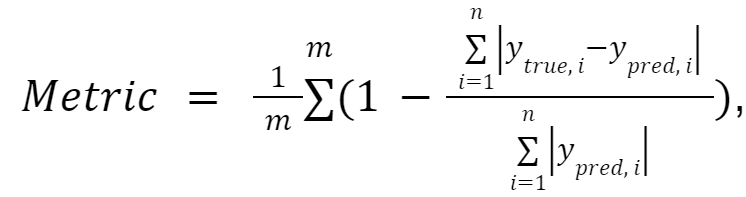

где n - количество периодов в году, m - количество элементов в тестовой выборке.  
Для данной метрики наилучшим результатом будет значение 1, метрика может уходить в отрицательные значения.


In [54]:
# Разделим выборку на обучающую и тестовую
train = out_df[out_df['cut_date'] < '2021.12.01'].drop('cut_date',axis=1)
test = out_df[(out_df['cut_date'] > '2021.12.31') & (out_df['cut_date'] < '2022.01.06')].drop('cut_date',axis=1)

In [55]:
# Реальные значения месячных потреблений тестовой выборки
Y_test_month = out_df[out_df['year'] == 2022].groupby(['analog_group', (pd.Grouper(key="cut_date", freq="MS"))]).agg({'out_bmu_sum':'sum'})
Y_test_month = Y_test_month.reset_index()

# Реальные значения квартальных потреблений тестовой выборки
Y_test_quarter = out_df[out_df['year'] == 2022].groupby(['analog_group', (pd.Grouper(key="cut_date", freq="QS"))]).agg({'out_bmu_sum':'sum'})
Y_test_quarter = Y_test_quarter.reset_index()

### Sarima

Построим авторегрессионную модель, прогнозирующую потребление трубы НКТ. Для начала рассмотрим прогнозирование помесячное, а затем попробуем построить прогноз относительно кварталов

In [56]:
out_df_for_sarima = out_df[out_df['cut_date'] < '2023.01.01']

In [57]:
def sarima_train_month(df):
  """
  Функция обучения и прогнозирования потребления трубы НКТ 
  на 2022 год по месяцам с помощью Sarima
  """

  predict_dict = {}

  for sg in df['analog_group'].unique():
    df_sg = df[df['analog_group'] == sg]
    df_groupby = df_sg.groupby(pd.Grouper(key="cut_date", freq="MS")).agg({'out_bmu_sum':'sum'})
    train = df_groupby.iloc[:60]
    test = df_groupby.iloc[60:]
    model = auto_arima(y = train.out_bmu_sum, m=12)
    predictions = np.array(model.predict(n_periods=len(test)))

    predict_dict[sg] = predictions
  
  return predict_dict

In [58]:
sarima_predict_month = sarima_train_month(out_df_for_sarima)

In [59]:
def regr_metric_sarima(y_true, y_predict):
  """
  Функция расчета метрики регрессии для Sarima
  """

  metric_dict = {}
  for sg in y_true['analog_group'].unique():
    y_true_sg = np.array(y_true[y_true['analog_group'] == sg]['out_bmu_sum'])
    y_predict_sg = y_predict[sg]

    days_metrics = []
    for day in y_predict_sg:
      diff_sum = sum(list(abs(y_true_sg - y_predict_sg)))
      sum_pred = sum(list(abs(y_predict_sg)))
      metric = 1 - (diff_sum/sum_pred)
      days_metrics.append(metric)

    sum_metric = sum(days_metrics)
    mean_metric = sum_metric/len(days_metrics)
    metric_dict[sg]=mean_metric

  return metric_dict

In [60]:
sarima_metric_month = regr_metric_sarima(Y_test_month, sarima_predict_month)

In [61]:
for sg, metric in sarima_metric_month.items():
  print(f'Для {sg} метрика месячного потребления трубы равна - {metric}')

Для nkt_114x7 метрика месячного потребления трубы равна - -0.45878476019863174
Для nkt_48x4 метрика месячного потребления трубы равна - 0.5112085087357298
Для nkt_60x5 метрика месячного потребления трубы равна - 0.3265749496875192
Для nkt_73x5p5 метрика месячного потребления трубы равна - 0.601139384331721
Для nkt_89x6p5 метрика месячного потребления трубы равна - 0.4788812249735593


Как можно наблюдать, показатели метрик помесячных потреблений достаточно низкие, так как в 2022 году потребление достаточно неравномерное. попробуем построить прогноз относительно кварталов

In [62]:
def sarima_train_quarter(df):
  """
  Функция обучения модели прогнозирования потребления трубы НКТ 
  на 2022 год по кварталам с помощью Sarima
  """
  models_dict = {}
  for sg in df['analog_group'].unique():
    df_sg = df[df['analog_group'] == sg]
    df_groupby = df_sg.groupby(pd.Grouper(key="cut_date", freq="QS")).agg({'out_bmu_sum':'sum'})
    train = df_groupby.iloc[:20]
    model = auto_arima(y = train.out_bmu_sum, m=4, random_state=21)
    models_dict[sg] = model
  
  return models_dict

In [63]:
def sarima_predict_quarter(models_dict, df):
  """
  Функция прогнозирования потребления трубы НКТ 
  на 2022 год по кварталам с помощью Sarima
  """

  predict_dict = {}

  for sg in df['analog_group'].unique():
    df_sg = df[df['analog_group'] == sg]
    df_groupby = df_sg.groupby(pd.Grouper(key="cut_date", freq="QS")).agg({'out_bmu_sum':'sum'})
    test = df_groupby.iloc[20:]
    predictions = np.array(models_dict[sg].predict(n_periods=len(test)))

    predict_dict[sg] = predictions
  
  return predict_dict

In [64]:
sarima_model = sarima_train_quarter(out_df_for_sarima)

In [65]:
sarima_predict_quarter = sarima_predict_quarter(sarima_model, out_df_for_sarima)

In [66]:
sarima_metric_quarter = regr_metric_sarima(Y_test_quarter, sarima_predict_quarter)

In [67]:
for sg, metric in sarima_metric_quarter.items():
  print(f'Для {sg} метрика квартального потребления трубы равна - {metric}')

Для nkt_114x7 метрика квартального потребления трубы равна - 0.293937912802236
Для nkt_48x4 метрика квартального потребления трубы равна - 0.6828066245938631
Для nkt_60x5 метрика квартального потребления трубы равна - 0.3978104691181594
Для nkt_73x5p5 метрика квартального потребления трубы равна - 0.7327203585583075
Для nkt_89x6p5 метрика квартального потребления трубы равна - 0.7930346785480479


Метрики стали в разы лучше. Посмотрим графики предсказанных потреблений для каждой синтез-группы

In [68]:
df_sarima_metric_quarter = pd.DataFrame(sarima_metric_quarter.items(), columns=['analog_group', 'metric'])
df_sarima_metric_quarter['model'] = 'Sarima'

In [69]:
def plot_true_and_pred_sarima_quarter(y_true, y_predict):
  """
  Функция визуализации графиков реальных значений потребления трубы НКТ 
  по кварталам за 2022 год и предсказанных значений для Sarima 
  """

  for sg in y_true['analog_group'].unique():
    y_true_sg = np.array(y_true[y_true['analog_group'] == sg]['out_bmu_sum'])
    y_predict_sg = y_predict[sg]

    fig = px.line(x=['Первый квартал','Второй квартал','Третий квартал','Четвертый квартал'], y=[y_true_sg, y_predict_sg], title = f'Квартальные предсказания для {sg}')
    fig.update_layout(
                xaxis_title="Квартал",
                yaxis_title="Потребление трубы (М)",
                legend_title='Значения')
    fig.data[0].name = 'Реальные значения'
    fig.data[1].name = 'Предсказанные значения'
    fig.show()

In [70]:
plot_true_and_pred_sarima_quarter(Y_test_quarter, sarima_predict_quarter)

Для большинства СГ, кроме nkt_114x7, модель хорошо строит прогноз.

### Случайный лес

Реализуем модель бэггинга деревьев решений - случайный лес. Для данного алгоритма уже понадобятся датасет со всеми созданными фичами

In [71]:
def rfr_train_with_default_params_month(train, test):
  """
  Функция обучения модели алгоритмом случаного леса с 
  дефолтными параметрами и предсказания помесячного потребления трубы
  """

  predict_dict = {}

  # Обучаем для каждой СГ отдельно 
  for sg in train['analog_group'].unique():
    X_train = train[train['analog_group']==sg].loc[:,'analog_group':'yearday']
    X_train = X_train.drop('analog_group', axis=1)
    Y_train = train[train['analog_group']==sg].loc[:,'target_smoothed_month_0':'target_smoothed_month_11']

    X_test = test[test['analog_group']==sg].loc[:,'analog_group':'yearday']
    X_test = X_test.drop('analog_group', axis=1)

    rfr = RandomForestRegressor(random_state=42)
    rfr.fit(X_train,Y_train)

    sg_predict = rfr.predict(X_test)
    predict_dict[sg]=sg_predict

  return predict_dict

In [72]:
rfr_test_predict_month = rfr_train_with_default_params_month(train, test)

In [73]:
def regr_metric(y_true, y_predict):
  """
  Функция расчета метрики регрессии
  """
  metric_dict = {}
  for sg in y_true['analog_group'].unique():
    y_true_sg = np.array(y_true[y_true['analog_group'] == sg]['out_bmu_sum'])
    y_predict_sg = y_predict[sg]

    days_metrics = []
    for day in y_predict_sg:
      diff_sum = sum(list(abs(y_true_sg - y_predict_sg)[0]))
      sum_pred = sum(list(abs(y_predict_sg)[0]))
      metric = 1 - (diff_sum/sum_pred)
      days_metrics.append(metric)

    sum_metric = sum(days_metrics)
    mean_metric = sum_metric/len(days_metrics)
    metric_dict[sg]=mean_metric

  return metric_dict

In [74]:
rfr_test_metric_month = regr_metric(Y_test_month, rfr_test_predict_month)

In [75]:
for sg, metric in rfr_test_metric_month.items():
  print(f'Для {sg} метрика месячного потребления трубы равна - {metric}')

Для nkt_114x7 метрика месячного потребления трубы равна - -0.25629292502337697
Для nkt_48x4 метрика месячного потребления трубы равна - 0.03743326429279925
Для nkt_60x5 метрика месячного потребления трубы равна - 0.5362706358583451
Для nkt_73x5p5 метрика месячного потребления трубы равна - 0.4994032077453171
Для nkt_89x6p5 метрика месячного потребления трубы равна - 0.43049958548674094


Как можно наблюдать, показатели метрик достаточно малы. Так как потрбление трубы неравномерное в течении года, достаточно трудно предсказать его потребление в конкретный месяц. Далее обучим модель на предсказание квартальных потреблений трубы и посмотрим метрики.

In [76]:
def rfr_train_with_default_params_quarter(train):
  """
  Функция обучения модели алгоритмом случаного леса с 
  дефолтными параметрами и предсказания квартального потребления трубы
  """

  models_dict = {}

  # Обучаем для каждой СГ отдельно 
  for sg in train['analog_group'].unique():
    X_train = train[train['analog_group']==sg].loc[:,'analog_group':'yearday']
    X_train = X_train.drop('analog_group', axis=1)
    Y_train = train[train['analog_group']==sg].loc[:,'target_smoothed_quarter_0':'target_smoothed_quarter_3']

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train,Y_train)

    models_dict[sg] = model

  return models_dict

In [77]:
def rfr_predict_with_default_params_quarter(models_dict, test):
  """
  Функция предсказания квартального потребления 
  трубы с помощью алгоритма случайного леса
  """

  predict_dict = {}

  # Обучаем для каждой СГ отдельно 
  for sg in train['analog_group'].unique():

    X_test = test[test['analog_group']==sg].loc[:,'analog_group':'yearday']
    X_test = X_test.drop('analog_group', axis=1)

    sg_predict = models_dict[sg].predict(X_test)
    predict_dict[sg]=sg_predict

  return predict_dict

In [78]:
rfr_model = rfr_train_with_default_params_quarter(train)

In [79]:
rfr_test_predict_quarter = rfr_predict_with_default_params_quarter(rfr_model, test)

In [80]:
rfr_test_metric_quarter = regr_metric(Y_test_quarter, rfr_test_predict_quarter)

In [81]:
for sg, metric in rfr_test_metric_quarter.items():
  print(f'Для {sg} метрика квартального потребления трубы равна - {metric}')

Для nkt_114x7 метрика квартального потребления трубы равна - 0.7428713455186733
Для nkt_48x4 метрика квартального потребления трубы равна - 0.5298212228491993
Для nkt_60x5 метрика квартального потребления трубы равна - 0.5817324107662194
Для nkt_73x5p5 метрика квартального потребления трубы равна - 0.5249096808779918
Для nkt_89x6p5 метрика квартального потребления трубы равна - 0.8279425254126551


In [82]:
df_rfr_test_metric_quarter = pd.DataFrame(rfr_test_metric_quarter.items(), columns=['analog_group', 'metric'])
df_rfr_test_metric_quarter['model'] = 'Случайный лес'

Показатели метрик стали достаточно большими, от 0.5. Для nkt_89x6p5 она превышает 0.82. Рассмотрим графики реальных значений потреблений трубы и предсказанные нашей моделью

In [83]:
def plot_true_and_pred_quarter(y_true, y_predict):
  """
  Функция визуализации графиков реальных значений потребления трубы НКТ 
  по кварталам за 2022 год и предсказанных значений
  """

  for sg in y_true['analog_group'].unique():
    y_true_sg = np.array(y_true[y_true['analog_group'] == sg]['out_bmu_sum'])
    y_predict_sg = np.mean(y_predict[sg], axis=0)

    fig = px.line(x=['Первый квартал','Второй квартал','Третий квартал','Четвертый квартал'], y=[y_true_sg, y_predict_sg], title = f'Квартальные предсказания для {sg}')
    fig.update_layout(
                xaxis_title="Квартал",
                yaxis_title="Потребление трубы (М)",
                legend_title='Значения')
    fig.data[0].name = 'Реальные значения'
    fig.data[1].name = 'Предсказанные значения'
    fig.show()

In [84]:
plot_true_and_pred_quarter(Y_test_quarter, rfr_test_predict_quarter)

Для некоторых СГ модель достаточно хорошо предсказывает потребление, а в некоторых случаях видны разбросы значений, появляющиеся при аномальных значениях потреблений, например в конце 2022 года для nkt48x4.

### Catboost

Далее обучим модель бустинга также для квартальных предсказаний потребления трубы и сравним результаты с предыдущими алгоритмами

In [85]:
def catboost_train_with_default_params(train, test):
  """
  Функция обучения модели catboost с 
  дефолтными параметрами и предсказания квартального потребления трубы
  """

  predict_dict = {}

  # Обучаем для каждой СГ отдельно 
  for sg in train['analog_group'].unique():
    X_train = train[train['analog_group']==sg].loc[:,'analog_group':'yearday']
    X_train = X_train.drop('analog_group', axis=1)
    Y_train = train[train['analog_group']==sg].loc[:,'target_smoothed_quarter_0':'target_smoothed_quarter_3']

    X_test = test[test['analog_group']==sg].loc[:,'analog_group':'yearday']
    X_test = X_test.drop('analog_group', axis=1)

    catboost = MultiOutputRegressor(CatBoostRegressor(random_seed=42, verbose=False))
    catboost.fit(X_train,Y_train)

    sg_predict = catboost.predict(X_test)
    predict_dict[sg]=sg_predict

  return predict_dict

In [86]:
catboost_test_predict_quarter = catboost_train_with_default_params(train, test)

In [87]:
catboost_test_metric_quarter = regr_metric(Y_test_quarter, catboost_test_predict_quarter)

In [88]:
for sg, metric in catboost_test_metric_quarter.items():
  print(f'Для {sg} метрика квартального потребления трубы равна - {metric}')

Для nkt_114x7 метрика квартального потребления трубы равна - 0.530610045680086
Для nkt_48x4 метрика квартального потребления трубы равна - 0.4330147574632135
Для nkt_60x5 метрика квартального потребления трубы равна - 0.46258543693083276
Для nkt_73x5p5 метрика квартального потребления трубы равна - 0.3804881097158388
Для nkt_89x6p5 метрика квартального потребления трубы равна - 0.7647009972431498


In [89]:
df_catboost_test_metric_quarter = pd.DataFrame(catboost_test_metric_quarter.items(), columns=['analog_group', 'metric'])
df_catboost_test_metric_quarter['model'] = 'Catboost с дефолтными параметрами'

Показатели метрик для всех синтез-групп чуть хуже, чем у случайного леса

С помощью поиска по сетке подберем параметры случайного леса для каждой нашей модели. Подбираемыми параметрами были выбраны: максимальная глубина дерева, минимальное количество выборок, необходимое для разделения внутреннего узла дерева, минимальное количество выборок, необходимое для конечного узла дерева, а также количество деревьев в лесу.

In [90]:
catboost_params = {'estimator__depth':[6,8,10],
                  'estimator__learning_rate':[0.01, 0.05, 0.1],
                  'estimator__iterations':[50, 100]
                  }

In [91]:
def catboost_train_with_searchCV(train, test):
  params = {}

  # Обучаем для каждой СГ отдельно 
  for sg in train['analog_group'].unique():
    X_train = train[train['analog_group']==sg].loc[:,'analog_group':'yearday']
    X_train = X_train.drop('analog_group', axis=1)
    Y_train = train[train['analog_group']==sg].loc[:,'target_smoothed_quarter_0':'target_smoothed_quarter_3']

    X_test = test[test['analog_group']==sg].loc[:,'analog_group':'yearday']
    X_test = X_test.drop('analog_group', axis=1)

    catboost = CatBoostRegressor(random_seed=42, verbose=False)
    catboost_random = RandomizedSearchCV(MultiOutputRegressor(catboost), param_distributions = catboost_params, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
    catboost_random.fit(X_train,Y_train)

    best_params = catboost_random.best_params_
    params[sg]=best_params

  return params

In [ ]:
catboost_train_with_searchCV(train, test)

{'nkt_114x7': {'estimator__learning_rate': 0.05,
  'estimator__iterations': 50,
  'estimator__depth': 8},
 'nkt_48x4': {'estimator__learning_rate': 0.05,
  'estimator__iterations': 50,
  'estimator__depth': 6},
 'nkt_60x5': {'estimator__learning_rate': 0.01,
  'estimator__iterations': 50,
  'estimator__depth': 6},
 'nkt_73x5p5': {'estimator__learning_rate': 0.01,
  'estimator__iterations': 100,
  'estimator__depth': 6},
 'nkt_89x6p5': {'estimator__learning_rate': 0.1,
  'estimator__iterations': 50,
  'estimator__depth': 8}}

In [92]:
params = {'nkt_114x7': {'learning_rate': 0.05,
  'iterations': 50,
  'depth': 8},
 'nkt_48x4': {'learning_rate': 0.05,
  'iterations': 50,
  'depth': 6},
 'nkt_60x5': {'learning_rate': 0.01,
  'iterations': 50,
  'depth': 6},
 'nkt_73x5p5': {'learning_rate': 0.01,
  'iterations': 100,
  'depth': 6},
 'nkt_89x6p5': {'learning_rate': 0.1,
  'iterations': 50,
  'depth': 8}}

In [93]:
def catboost_train_with_params(train, test, params):
  """
  Функция обучения модели catboost с 
  подобранными параметрами и предсказания квартального потребления трубы
  """

  predict_dict = {}

  # Обучаем для каждой СГ отдельно 
  for sg in train['analog_group'].unique():
    X_train = train[train['analog_group']==sg].loc[:,'analog_group':'yearday']
    X_train = X_train.drop('analog_group', axis=1)
    Y_train = train[train['analog_group']==sg].loc[:,'target_smoothed_quarter_0':'target_smoothed_quarter_3']

    X_test = test[test['analog_group']==sg].loc[:,'analog_group':'yearday']
    X_test = X_test.drop('analog_group', axis=1)

    rfr = MultiOutputRegressor(CatBoostRegressor(random_seed=42, verbose=False, **params[sg]))
    rfr.fit(X_train,Y_train)

    sg_predict = rfr.predict(X_test)
    predict_dict[sg]=sg_predict

  return predict_dict

In [94]:
catboost_test_predict_with_params_quarter = catboost_train_with_params(train, test, params)

In [95]:
catboost_test_metric_with_params_quarter = regr_metric(Y_test_quarter, catboost_test_predict_with_params_quarter)

In [96]:
for sg, metric in catboost_test_metric_with_params_quarter.items():
  print(f'Для {sg} метрика квартального потребления трубы равна - {metric}')

Для nkt_114x7 метрика квартального потребления трубы равна - 0.5122404163742176
Для nkt_48x4 метрика квартального потребления трубы равна - 0.4767046982391432
Для nkt_60x5 метрика квартального потребления трубы равна - 0.3794006895055917
Для nkt_73x5p5 метрика квартального потребления трубы равна - 0.3951010485359603
Для nkt_89x6p5 метрика квартального потребления трубы равна - 0.7941799912660381


In [97]:
df_catboost_test_metric_with_params_quarter = pd.DataFrame(catboost_test_metric_with_params_quarter.items(), columns=['analog_group', 'metric'])
df_catboost_test_metric_with_params_quarter['model'] = 'Catboost с настроенными параметрами'

In [98]:
plot_true_and_pred_quarter(Y_test_quarter, catboost_test_predict_with_params_quarter)

## Сравнение моделей

In [99]:
df_metrics = pd.concat([df_sarima_metric_quarter,df_rfr_test_metric_quarter,df_catboost_test_metric_quarter,df_catboost_test_metric_with_params_quarter]).reset_index(drop=True)

In [100]:
fig = px.bar(df_metrics, x="analog_group", y="metric",
             color='model', barmode='group', title='Сравнение алгоритмов для каждой СГ',
             height=500)
fig.show()

### Лучшие модели для каждой СГ:

In [101]:
out_df['analog_group'].unique()

array(['nkt_114x7', 'nkt_48x4', 'nkt_60x5', 'nkt_73x5p5', 'nkt_89x6p5'],
      dtype=object)

* **nkt_114x7** - Случайный лес
* **nkt_48x4** - Sarima
* **nkt_60x5** - Случайный лес
* **nkt_73x5p5** - Sarima
* **nkt_89x6p5** - Случайный лес

## Прогноз потребления

Далее выберем для каждой синтез-группы лучшую модель и постоим предсказание потребление трубы НКТ на 2023 год

In [102]:
df_for_predict = out_df[(out_df['cut_date'] > '2022.12.31') & (out_df['cut_date'] < '2023.01.06')].drop('cut_date',axis=1)
df_for_predict = df_for_predict.loc[:,'analog_group':'yearday']

In [103]:
# Лучшие модели для каждой СГ
model_nkt_114x7 = rfr_model['nkt_114x7']
model_nkt_48x4 = sarima_model['nkt_48x4']
model_nkt_60x5 = rfr_model['nkt_60x5']
model_nkt_73x5p5 = rfr_model['nkt_73x5p5']
model_nkt_89x6p5 = rfr_model['nkt_89x6p5']

In [104]:
df_nkt_114x7 = df_for_predict[df_for_predict['analog_group'] == 'nkt_114x7'].drop('analog_group',axis=1)
predict_nkt_114x7 = np.mean(model_nkt_114x7.predict(df_nkt_114x7), axis=0)

In [105]:
def predict_plot(predict, sg):
    """
    Функция построения графика прогнозов потребления трубы на 2023 год
    """

    df_predict = pd.DataFrame(predict, columns = ['out_bmu_sum'])
    df_predict['cut_date'] = ['2023.01.01', '2023.04.01','2023.07.01','2023.10.01']
    df_predict['cut_date'] = pd.to_datetime(df_predict['cut_date'])
    df_predict['Потребления'] = 'Предсказания'
  
    df_old = out_df[(out_df['cut_date'] < '2023.01.01') & (out_df['cut_date'] >= '2021.01.01') & (out_df['analog_group'] == sg)]
    df_old_groupby = df_old.groupby(pd.Grouper(key="cut_date", freq="QS")).agg({'out_bmu_sum':'sum'})
    df_old_groupby = df_old_groupby.reset_index()
    df_old_groupby.loc[df_old_groupby.shape[0]] = ['2023.01.01', df_predict.loc[0,'out_bmu_sum']]
    df_old_groupby['Потребления'] = 'Реальные значения'

    tdf = pd.concat([df_old_groupby, df_predict])

    fig = px.line(tdf, x = 'cut_date', y = 'out_bmu_sum', color='Потребления', title = f'Квартальные предсказания потребления трубы на 2023 год для {sg}')
    fig.update_layout(
                xaxis_title="Квартал",
                yaxis_title="Потребление трубы (М)")
    fig.show()

In [106]:
predict_plot(predict_nkt_114x7, 'nkt_114x7')

In [107]:
df_nkt_60x5 = df_for_predict[df_for_predict['analog_group'] == 'nkt_60x5'].drop('analog_group',axis=1)
predict_nkt_60x5 = np.mean(model_nkt_60x5.predict(df_nkt_60x5), axis=0)

In [108]:
predict_plot(predict_nkt_60x5, 'nkt_60x5')

In [109]:
df_nkt_89x6p5 = df_for_predict[df_for_predict['analog_group'] == 'nkt_89x6p5'].drop('analog_group',axis=1)
predict_nkt_89x6p5 = np.mean(model_nkt_89x6p5.predict(df_nkt_89x6p5), axis=0)

In [110]:
predict_plot(predict_nkt_89x6p5, 'nkt_89x6p5')

In [111]:
df_nkt_48x4 = out_df_for_sarima[out_df_for_sarima['analog_group'] == 'nkt_48x4']
train = df_nkt_48x4.groupby(pd.Grouper(key="cut_date", freq="QS")).agg({'out_bmu_sum':'sum'})
model = auto_arima(y = train.out_bmu_sum, m=4, random_state=21)
predict_nkt_48x4 = np.array(model.predict(n_periods=4))

In [112]:
predict_plot(predict_nkt_48x4, 'nkt_48x4')

In [113]:
df_nkt_73x5p5 = df_for_predict[df_for_predict['analog_group'] == 'nkt_73x5p5'].drop('analog_group',axis=1)
predict_nkt_73x5p5 = np.mean(model_nkt_73x5p5.predict(df_nkt_73x5p5), axis=0)

In [114]:
predict_plot(predict_nkt_73x5p5, 'nkt_73x5p5')